In [3]:
import pynetlogo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygame
import json
from tqdm import tqdm, trange

pygame 2.4.0 (SDL 2.26.4, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
class NetLogoWrapper:
    def __init__(self, *, model_file, config_file, render=False, jvm_path='/Applications/NetLogo 6.3.0/runtime/Contents/MacOS/libjli.dylib') -> None:
        self.netlogo = pynetlogo.NetLogoLink(gui=False, jvm_path=jvm_path)
        self.netlogo.load_model(model_file)

        # Load and apply config
        with open(config_file, 'r') as f:
            self.config = json.load(f)

        self.resolution = 10
        self.max_x_cor = self.config['evaluation']['max_x_cor']
        self.max_y_cor = self.config['evaluation']['max_y_cor']
        self.netlogo.command(f'resize-world {-self.max_x_cor} {self.max_x_cor} {-self.max_y_cor} {self.max_y_cor}')
        self.netlogo.command(f'set num-cars {self.config["evaluation"]["num_cars"]}')
        self.netlogo.command(f'set num-garages {self.config["evaluation"]["num_garages"]}')
        self.netlogo.command(f'set demand-curve-intercept {self.config["evaluation"]["demand_curve_intercept"]}')
        self.netlogo.command(f'set lot-distribution-percentage {self.config["evaluation"]["lot_distribution_percentage"]}')
        self.netlogo.command(f'set target-start-occupancy {self.config["evaluation"]["target_start_occupancy"]}')

        if render:
            pygame.init()
            self.screen = pygame.display.set_mode((self.resolution * (2 * self.max_x_cor + 1), self.resolution * (2 * self.max_y_cor + 1)))
            print(f'size: {self.resolution * (2 * self.max_x_cor + 1)} x {self.resolution * (2 * self.max_y_cor + 1)}')
            pygame.display.set_caption('Restricted Parking')
            
        else:
            self.screen = None
            self.netlogo.command('no-display')


    def setup(self):
        self.netlogo.command('setup')

    def step(self, number_of_steps=1):
        self.netlogo.repeat_command('go', number_of_steps)

    def report(self, variable):
        return self.netlogo.report(variable)

    def command(self, _command):
        self.netlogo.command(_command)

    def render_patches(self):
        self.screen.fill((0,0,0))

        for x, y, *color in self.netlogo.report('[(sentence pxcor pycor (ifelse-value (is-number? pcolor) [extract-rgb pcolor] [pcolor]))] of patches'):
            pygame.draw.rect(self.screen, color, pygame.Rect(*self.transform_coordinates(x, y), self.resolution, self.resolution))

        pygame.display.flip()
    
    def render(self):
        if not self.render:
            raise NotImplementedError
        else:
            self.screen.fill((0,0,0))
            pygame.display.flip()

    def close(self):
        pygame.quit()
        self.netlogo.kill_workspace()

    def transform_coordinates(self, x, y):
        return ((self.max_x_cor + x) * self.resolution, (self.max_y_cor - y) * self.resolution)
    
    def __exit__(self):
        self.close()

In [3]:
class ParkingGovernance:
    def __init__(self, netlogo) -> None:
        self.netlogo = netlogo

    def act(self):
        pass

In [16]:
wrapper = NetLogoWrapper(model_file='model.nlogo', config_file='model_config.json', render=False)
wrapper.setup()

In [89]:
print(wrapper.report('count lots'))
wrapper.command('ask original-yellow-lot [set allowed? false]')
wrapper.command('update-parking')
print(wrapper.report('count lots'))

234.0
210.0


In [90]:
print(wrapper.report('count lots'))
wrapper.command('ask original-blue-lot [set allowed? true]')
wrapper.command('update-parking')
print(wrapper.report('count lots'))

210.0
210.0


In [91]:
print(f'{wrapper.report("count original-blue-lot")=}')

wrapper.report("count original-blue-lot")=68.0


In [92]:
pd.Series(wrapper.report("[lot-id] of original-lots")).describe()

count    234.000000
mean       8.042735
std        4.442080
min        1.000000
25%        4.000000
50%        8.000000
75%       12.000000
max       15.000000
dtype: float64

In [54]:
COLORS = {'yellow': (255, 255, 102), 
          'green': (123, 174, 116), 
          'teal': (57, 107, 148), 
          'blue': (26, 51, 179),
          'black': (0, 0, 0)
          }

LOT_COLORS = ['yellow', 'green', 'teal', 'blue']

class ParkingSpace:
    def __init__(self, x, y, group, allowed, *, netlogo) -> None:
        self.netlogo = netlogo
        
        self.x, self.y, self.group = x, y, group
        self.allowed = allowed

    def is_garage(self):
        return self.group.type == 'garage'
    
    def __repr__(self) -> str:
        return f'({self.x:3}, {self.y:3})[{self.group.type[0].upper()}{self.group.id:2}]{" (disallowed)" if not self.allowed else ""}'

    def disallow(self):
        self.set_allowed(False)

    def allow(self):
        self.set_allowed(True)

    def set_allowed(self, allowed):
        self.allowed = allowed
        self.netlogo.command(f'ask patch {self.x} {self.y} [set allowed? {str(allowed).lower()}]')
        self.netlogo.command('update-parking')


class ParkingGroup:
    def __init__(self, id, type, color, *, netlogo) -> None:
        self.netlogo = netlogo
        
        self.id = id
        self.type = type
        self.color = color
        self.parking_spaces = []

    @property
    def allowed_spaces(self):
        return [space for space in self.parking_spaces if space.allowed]

    def __repr__(self) -> str:
        # return f'<ParkingGroup [{self.type[0].upper()}{self.id:2}] spaces={self.parking_spaces}>'
        return f'[{self.type[0].upper()}{self.id:2} ({self.color})] n={len(self.parking_spaces)}>'

    @property
    def degree_of_restriction(self):
        return 1.0 - len(self.allowed_spaces) / len(self.parking_spaces)

    def occupancy(self, include_disallowed=False):
        if include_disallowed:
            return self.netlogo.report(f'count cars-on (original-park-spaces with [lot-id = {self.id}]) / (count original-park-spaces with [lot-id = {self.id}])')
        else:
            return self.netlogo.report(f'count cars-on (park-spaces with [lot-id = {self.id}]) / count (park-spaces with [lot-id = {self.id}])')

In [55]:
def create_parking_model(netlogo):
    number_of_parking_lots = int(netlogo.report("lot-counter")) - 1
    number_of_parking_garages = int(netlogo.report("num-garages"))

    print(f'{number_of_parking_lots=}, {number_of_parking_garages=}')

    parking_groups = {**{id: ParkingGroup(id, 'lot', color=None, netlogo=netlogo) for id in range(1, number_of_parking_lots + 1)}, **{id: ParkingGroup(id, 'garage', color=None, netlogo=netlogo) for id in range(number_of_parking_lots + 1, number_of_parking_lots + number_of_parking_garages + 1)}}

    for x, y, group_id, allowed in netlogo.report("[(list pxcor pycor lot-id ifelse-value allowed? [1] [0])] of original-lots"):
        parking_groups[group_id].parking_spaces.append(ParkingSpace(int(x), int(y), parking_groups[group_id], bool(allowed), netlogo=netlogo))

    for x, y, group_id, allowed in netlogo.report("[(list pxcor pycor lot-id ifelse-value allowed? [1] [0])] of original-garages"):
        parking_groups[group_id].parking_spaces.append(ParkingSpace(int(x), int(y), parking_groups[group_id], bool(allowed), netlogo=netlogo))

    inverse_colors = {color: name for name, color in COLORS.items()}
    for parking_group in parking_groups.values():
        parking_group.parking_spaces.sort(key=lambda space: (space.x, space.y))
        # print(f'{parking_group=}, {netlogo.report(f"[pcolor] of patch {parking_group.parking_spaces[0].x} {parking_group.parking_spaces[0].y}")=}')
        parking_group.color = inverse_colors[tuple(map(int, netlogo.report(f'[pcolor] of patch {parking_group.parking_spaces[0].x} {parking_group.parking_spaces[0].y}')))]

    return parking_groups

In [70]:
def run_baseline():
    number_of_intervals = 5
    number_of_steps_per_interval = 900

    wrapper = NetLogoWrapper(model_file='model.nlogo', config_file='model_config.json')
    
    cruising = []
    score = 0

    statistics = pd.DataFrame(index=range(number_of_intervals), columns=['search-time'])
    
    wrapper.setup()
    parking_groups = create_parking_model(wrapper)
    occupancy = pd.DataFrame(index=range(number_of_intervals), columns=parking_groups.values())
    wrapper.command("ask one-of cars [record-data]")

    for parking_space in parking_groups[1].parking_spaces[:-2]:
        parking_space.disallow()

    for i in tqdm(range(number_of_intervals)):
        wrapper.step(number_of_steps_per_interval)
        cruising.append(wrapper.report("share-cruising"))
        for c in LOT_COLORS:
            occup = wrapper.report(f"{c}-lot-current-occup")
            if 0.75 < occup < 0.9:
                score += 0.25

        occupancy.iloc[i] = [parking_group.occupancy(include_disallowed=True) for parking_group in parking_groups.values()]

        data = wrapper.report('[list search-time fav-lot-id] of cars')


    # document_episode(nl=nl, path=outpath, reward_sum=score)
    print(f'{score=}')
    print(f'{wrapper.report("traffic-counter")=}')
    print(f'{np.mean(cruising)=}')

    # occupancy.plot()

    wrapper.close()

number_of_parking_lots=20, number_of_parking_garages=2


100%|██████████| 24/24 [01:31<00:00,  3.80s/it]


score=7.75
wrapper.report("traffic-counter")=18168.0
np.mean(cruising)=0.2725249277951133


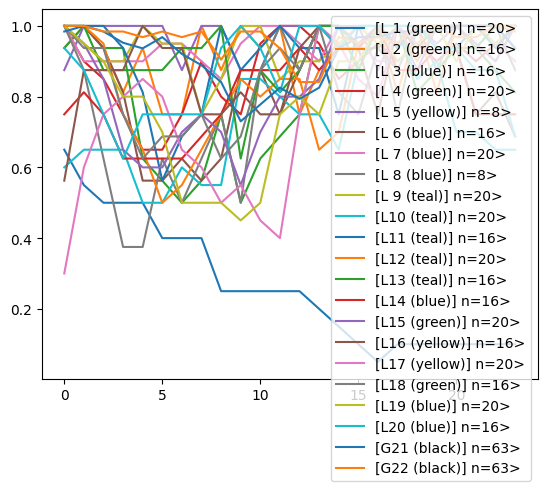

In [71]:
run_baseline()

In [103]:
number_of_steps_per_interval = 900

wrapper = NetLogoWrapper(model_file='model.nlogo', config_file='model_config.json')

cruising = []
score = 0

wrapper.setup()
parking_groups = create_parking_model(wrapper)
wrapper.command("ask one-of cars [record-data]")

# for parking_space in parking_groups[1].parking_spaces[:-2]:
#     parking_space.disallow()

number_of_parking_lots=19, number_of_parking_garages=2


In [105]:
{(int(x), int(y)): bool(allowed) for x, y, allowed in wrapper.report('allowed-parking-spaces')}

{(13, -33): True,
 (-11, 43): True,
 (3, -9): True,
 (7, 41): True,
 (-11, -41): True,
 (3, 43): True,
 (-27, -41): True,
 (-14, 43): True,
 (17, 22): True,
 (-12, -13): True,
 (-19, 36): True,
 (-8, -13): True,
 (6, -8): True,
 (-13, -7): True,
 (1, -6): True,
 (16, 22): True,
 (-26, 20): True,
 (13, -9): True,
 (21, 22): True,
 (-13, 43): True,
 (-4, 29): True,
 (13, 27): True,
 (-10, -13): True,
 (23, -22): True,
 (-32, 8): True,
 (-8, -9): True,
 (11, 8): True,
 (-17, 12): True,
 (13, 35): True,
 (-10, -43): True,
 (-7, 22): True,
 (1, 43): True,
 (17, 1): True,
 (6, -10): True,
 (13, -8): True,
 (20, -20): True,
 (-8, -11): True,
 (4, -11): True,
 (-10, -9): True,
 (-23, -41): True,
 (3, -12): True,
 (-4, 30): True,
 (-14, -10): True,
 (-14, 41): True,
 (11, 34): True,
 (-13, -6): True,
 (3, -14): True,
 (3, -6): True,
 (7, -7): True,
 (-14, -43): True,
 (-11, -10): True,
 (-9, -14): True,
 (-4, 28): True,
 (3, 41): True,
 (1, -13): True,
 (-4, 36): True,
 (5, 41): True,
 (11, 29)

In [20]:
road_sections = pd.DataFrame(wrapper.report('[(list pxcor pycor road-section)] of patches'), columns=['x', 'y', 'section']).sort_values(['x', 'y'])
road_sections[road_sections['section'] == 1]

,x,y,section
948,-18.0,-41.0,1.0
6877,-18.0,-40.0,1.0
4372,-18.0,-39.0,1.0
7577,-18.0,-38.0,1.0
3437,-18.0,-37.0,1.0
6343,-18.0,-36.0,1.0
1610,-18.0,-35.0,1.0
3049,-18.0,-34.0,1.0
615,-18.0,-33.0,1.0
6886,-18.0,-32.0,1.0


In [108]:
wrapper.step(number_of_steps_per_interval)
data = wrapper.report('[list search-time (ifelse-value is-list? fav-lot-id and not empty? fav-lot-id [first fav-lot-id] [0])] of cars')
data

array([[ 0., 21.],
       [ 0.,  0.],
       [ 0., 21.],
       ...,
       [ 0., 21.],
       [ 0., 10.],
       [ 0., 17.]])

In [101]:
x = pd.DataFrame(data, columns=['search_time', 'fav_lot_id']).groupby('fav_lot_id').mean().reset_index()
x['lot_color'] = x.apply(lambda row: parking_groups[int(row['fav_lot_id'])].color if row['fav_lot_id'] > 0 else 'n/a', axis=1)
x.groupby('lot_color').mean().reset_index()

,lot_color,fav_lot_id,search_time
0,black,21.500,228.027462
1,blue,10.875,366.530878
2,green,11.500,410.807755
3,n/a,0.000,2.513158
4,teal,7.000,208.137987
5,yellow,13.000,272.722222


In [106]:
for current_step in tqdm(range(number_of_steps_per_interval)):
    wrapper.step()
    allowed_parking_spaces = wrapper.report('allowed-parking-spaces')

100%|██████████| 900/900 [00:15<00:00, 59.78it/s]


# Read and analyze turtle data from NetLogo episodes

In [8]:
import pickle
import pandas as pd
import gzip

In [12]:
# with open('standard_max_9.75_turtles.pkl', 'rb') as f:
#     data = pickle.load(f)
#     valid_set = cPickle.load(f)
#     test_set = cPickle.load(f)
data = pd.read_pickle('standard_max_9.75_turtles.pkl', compression='zip')
data[data['wants-to-park'] == True]

,id,income,income-group,income-interval-survey,age,gender,school-degree,degree,wtp,parking-strategy,...,checked-blocks,egress,access,space-type,price-paid,search-time,wants-to-park,die?,reinitialize?,outcome
48,1518,4031,1,6,44,1,5,10,3.092269,3,...,0,4.875000,8.246211,garage,-99.00,0.000000,True,True,False,-10.000000
52,933,2475,1,5,48,2,5,5,3.538517,3,...,0,8.250000,2.150581,garage,-99.00,0.000000,True,True,False,-10.000000
263,1040,9557,2,7,45,1,5,10,11.860535,3,...,0,9.000000,2.795085,curb,-99.00,0.000000,True,True,False,-10.000000
373,1300,4068,1,5,25,2,5,8,5.535773,7,...,1,3.035294,3.335416,curb,0.00,3.035294,True,True,True,-0.072920
385,910,8565,2,7,36,2,5,9,6.641648,7,...,1,1.500000,12.311072,garage,2.00,0.000000,True,True,True,-2.845830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19474,19750,1652,0,4,74,2,3,12,1.619446,7,...,2,9.529412,14.346167,curb,0.00,16.623529,True,True,True,1.395626
19483,20340,4707,1,6,80,1,1,4,3.665886,3,...,1,5.929412,2.136001,garage,2.00,5.929412,True,True,True,-6.962991
19504,20288,3849,1,6,66,1,3,5,3.797306,5,...,2,11.752941,4.422952,curb,3.75,17.858824,True,True,True,-8.872929
19519,19099,1517,0,4,70,2,3,4,2.085299,5,...,1,4.482353,10.213349,garage,2.00,4.482353,True,True,True,1.101940


# Record traffic data in Netlogo

In [37]:
wrapper = NetLogoWrapper(model_file='model.nlogo', config_file='model_config.json')
wrapper.setup()

for i in trange(100):
    wrapper.step()
    wrapper.command('document-traffic')

wrapper.command('file-close')

100%|██████████| 100/100 [00:02<00:00, 47.16it/s]


In [38]:
traffic = pd.read_csv('traffic.csv')

In [42]:
sorted(traffic['road-section'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 26,
 27,
 29,
 30,
 32,
 34,
 35,
 38,
 39,
 40,
 41,
 43,
 44,
 45,
 47,
 49,
 50,
 51,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 64,
 67,
 69,
 73,
 75,
 76,
 78,
 79,
 82,
 86,
 87,
 89,
 97]

In [75]:
import networkx as nx

class RoadSection:
    def __init__(self, id, parking_groups=None) -> None:
        self.id = id
        self.parking_groups = parking_groups or []
        self.x, self.y = None, None

    def __repr__(self) -> str:
        return f'<RoadSection {self.id} [{self.x}, {self.y}]>'

In [54]:
netlogo = NetLogoWrapper(model_file='model.nlogo', config_file='model_config.json')
netlogo.setup()

In [76]:
def create_road_section_model(netlogo):
    road_sections = {}
    for id in map(int, netlogo.report('remove-duplicates [road-section] of patches')):
        road_section = RoadSection(id)
        patches = pd.DataFrame(netlogo.report(f'[list pxcor pycor] of patches with [road-section = {id}]'), columns=['x', 'y'])
        x_min, x_max, y_min, y_max = int(patches['x'].min()), int(patches['x'].max()), int(patches['y'].min()), int(patches['y'].max())

        road_section.x = x_min if x_min == x_max else (x_min, x_max)
        road_section.y = y_min if y_min == y_max else (y_min, y_max)

        road_sections[id] = road_section

    return road_sections

In [77]:
x = create_road_section_model(netlogo)

In [78]:
x

{27: <RoadSection 27 [(-40, -34), -42]>,
 0: <RoadSection 0 [(-40, 40), (-50, 50)]>,
 57: <RoadSection 57 [-18, (43, 50)]>,
 15: <RoadSection 15 [(-32, -19), -21]>,
 29: <RoadSection 29 [27, (1, 20)]>,
 64: <RoadSection 64 [(28, 40), -42]>,
 54: <RoadSection 54 [-3, (22, 41)]>,
 11: <RoadSection 11 [(-32, -19), 0]>,
 4: <RoadSection 4 [(13, 26), 42]>,
 61: <RoadSection 61 [27, (-41, -22)]>,
 3: <RoadSection 3 [(-2, 11), 42]>,
 8: <RoadSection 8 [(13, 26), 21]>,
 41: <RoadSection 41 [-3, (-20, -1)]>,
 88: <RoadSection 88 [(28, 40), 42]>,
 7: <RoadSection 7 [(-2, 11), 21]>,
 45: <RoadSection 45 [-3, (1, 20)]>,
 22: <RoadSection 22 [12, (-20, -1)]>,
 19: <RoadSection 19 [(-17, -4), -42]>,
 12: <RoadSection 12 [(-17, -4), 0]>,
 14: <RoadSection 14 [-18, (-41, -22)]>,
 17: <RoadSection 17 [-3, (-41, -22)]>,
 28: <RoadSection 28 [(-32, -19), -42]>,
 40: <RoadSection 40 [(-32, -19), 21]>,
 10: <RoadSection 10 [-18, (-20, -1)]>,
 55: <RoadSection 55 [(-17, -4), 42]>,
 30: <RoadSection 30 [27, 

# Run episode with different number of allowed parking spaces and compare results

In [15]:
COLORS = ['yellow', 'green', 'blue', 'teal']

In [35]:
def report_occupancy(netlogo):
    occupancy = {}
    for color in COLORS:
        occupancy[f'n_{color}'], occupancy[f'a_{color}'], occupancy[f'p_{color}'] = netlogo.report(f'(list count original-{color}-lot count {color}-lot count cars-on {color}-lot)')

    return occupancy

In [56]:
def report_traffic(netlogo):
    return pd.DataFrame(netlogo.report('report-traffic'), columns=['road_section', 'number_of_cars', 'mean_speed']).astype({'road_section': int, 'number_of_cars': int, 'mean_speed': float})

In [60]:
netlogo = NetLogoWrapper(model_file='model.nlogo', config_file='model_config.json')
netlogo.setup()

number_of_intervals = 100
number_of_steps_per_interval = 100

closing_schedule = (30, 'blue')

occupancy = []
for i in tqdm(range(number_of_intervals)):
    netlogo.step(number_of_steps_per_interval)
    
    occupancy.append(report_occupancy(netlogo))

    if i == closing_schedule[0]:
        netlogo.command(f'ask original-{closing_schedule[1]}-lot [set allowed? false]')
        netlogo.command('update-parking')

occupancy = pd.DataFrame(occupancy)

100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


<Axes: >

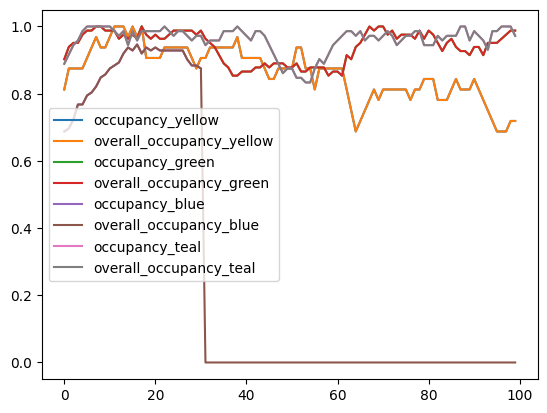

In [59]:
# Calculate occupancy w.r.t. allowed and all parking spaces from reported data
for color in COLORS:
    occupancy[f'occupancy_{color}'] = occupancy[f'p_{color}'] / occupancy[f'a_{color}']
    occupancy[f'overall_occupancy_{color}'] = occupancy[f'p_{color}'] / occupancy[f'n_{color}']

# Plot occupancy
occupancy[[f'{metric}_{color}' for color in COLORS for metric in ['occupancy', 'overall_occupancy']]].plot()

In [57]:
netlogo = NetLogoWrapper(model_file='model.nlogo', config_file='model_config.json')
netlogo.setup()

In [58]:
report_traffic(netlogo)

,road_section,number_of_cars,mean_speed
0,7,4,0.049500
1,1,1,0.099000
2,45,1,0.099000
3,9,7,0.084857
4,37,7,0.070714
...,...,...,...
56,15,4,0.049500
57,53,2,0.049500
58,35,2,0.099000
59,57,2,0.099000
